# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn import metrics
from sklearn.metrics import r2_score
from scipy.stats import lognorm 
from scipy.stats import kstest
import seaborn as sns

# Function

**removeOutliers(data, col, graph.No)**: By using 1.5 IQR to drop outliers.
* **Input** is sample data, target column and graph number. 
* **Output** is the dataset after drop outliers and the boxgraph.

**Statistics_Normal_test(sample, sample_acronym, graph.No)**: It is used to quickly check the statistics of the sample data and whether there are Nans and infinite decimals, etc. Moreover, it is used kstest to detect whether the sample data is in compound normal distribution and to plot the qqplot. H_0 means that the sample data obey the normal distribution, and H_1 means that the sample data do not obey the specific distribution, and the significance level is 0.05. When the p-value is greater than the significance level, the null hypothesis is not rejected, indicating that the specified sequence obeides normal distribution. In addition, it judges symmetry by skewness.
* **Input** is sample data and sample's acronym. 
* **Output** is all the data information, results and qqplot graph.
* **Return** is p-value.

**Fit_normal(sample, xlabel, Figure.No)**: It is used to fit normal distribution and draw graph. 
* **Input** is sample data, xlabel, and figure number. 
* **Output** is the graph. 
* **Return** is fitting data of the same length.


**Loss(sample,fitted_data)**: It is used to evaluate the fitting effect of normal distribution. The p value and error loss of kstest were calculated respectively, among which error loss included SSE, MSE, RMSE, MAE and MAPE. 
* **Input** is sample data and fitting fitting data. 
* **Output** is the above evaluation index.


In [2]:
# Removing the outliers
def removeOutliers(data, col, No):
    
    print(data[col].describe())
    
    plt.figure(figsize=(6, 4))
    sns.boxplot(x = data[col])
    plt.savefig(f"/kaggle/working/Graph_{No}.png")
    plt.show()
    
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]

In [3]:
def Statistics_Normal_test(sample, sample_acronym, No):
    sample.describe()
    
    print("Nan =", sample.isnull().sum())
    
    #The denominator is n-1
    mean = sample.mean()
    std = sample.std()
    var = (sample.std())**2
    skew = sample.skew()
    kurt = sample.kurt()
    
    print(f"{sample_acronym}_mean is", mean)
    print(f"{sample_acronym}_std is", std)
    print(f"{sample_acronym}_var is", var)
    print(f"{sample_acronym}_skew is", skew)
    print(f"{sample_acronym}_kurt is", kurt)
    
    
    Normal_test = kstest(sample, 'norm')
    print(f"{sample_acronym} as", Normal_test)
    p= Normal_test[1]
    
    if p>0.05:
        print("The data are normally distributed by Judging the p-value")
    else:
        print("The data aren't normally distributed by Judging the p-value")
    print("\n")
    
    print("It can be observed from qqplot that data is subject to normal distribution, which is caused by reasons such as kstest may not be applicable or data samples are not sufficient.")
    plt.figure(figsize=(6, 4))
    st.probplot(sample, dist="norm", plot=plt)
    
    plt.savefig(f"/kaggle/working/Graph_{No}.png")
    plt.show()
    
    if skew<1 and skew>-1:
        print("The distribution is symmetric by skew.")
    elif skew<-1:
        print("The distribution is skewed to the left tail which is negative.")
    elif skew>1:
        print("The distribution is skewed to the right tail which is positive.")
        
    return p

In [4]:
def Fit_normal(sample, xlabel, No):
    #Parameter 
    length = len(sample)
    bin_value = length-1
    mu = sample.mean()
    sigma = sample.std()
    
    #Figure
    plt.figure(figsize=(6, 4))
    plt.grid(ls='--',alpha=0.4)
    plt.xlabel(xlabel) 
    plt.ylabel('Count') 
    count, bins, _ = plt.hist(sample, bin_value, density=True, stacked=True, color='r', alpha=0.5)
    
    #Fitting
    fit = 1./(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
    
    plt.title(f'mu = {mu.round(4)} sigma = {sigma.round(4)}')
    plt.plot(bins, fit, color='b')
    
    plt.savefig(f"/kaggle/working/Figure_{No}.png")
    plt.show()
    
    return fit

In [5]:
def Loss(y_true,y_pre):
    SSE = np.sum((y_true - y_pre)**2)
    MSE = metrics.mean_squared_error(y_true,y_pre)
    RMSE = (metrics.mean_squared_error(y_true,y_pre))**0.5
    MAE = metrics.mean_absolute_error(y_true,y_pre)
    MAPE = metrics.mean_absolute_percentage_error(y_true,y_pre)
    #SST = np.sum((df["rt"].values - np.mean(df["rt"].values))**2)
    R2 = r2_score(y_true,y_pre)
    
    Normal_test = kstest(y_true, 'norm')
    p= Normal_test[1]
    
    print("SSE=",SSE, "\nMSE=",MSE, "\nRMSE=",RMSE, "\nMAE=",MAE, "\nMAPE=",MAPE, "\nR2=",R2, "\np-value=",p)
    
    loss=[SSE,MSE,RMSE,MAE,MAPE,R2,p]
    return loss

# Step 1: Pick one stock. 
Download its historical closing price series over some periods more than 
one year.

In [6]:
data = pd.read_csv("/kaggle/input/stock-601012/601012.csv")
data.head(5)
data = data[["日期","收盘价(元)"]]
data = data.rename ( {"日期":"date", "收盘价(元)":"close"}, axis="columns")
data=data.tail(500)

In [7]:
print(data.shape)
data.isnull().sum()

(500, 2)


date     2
close    2
dtype: int64

In [8]:
df = data.dropna(axis=0)
print(df.shape)
df.info

(498, 2)


<bound method DataFrame.info of             date   close
2146  2021-02-01  106.92
2147  2021-02-02  109.01
2148  2021-02-03  108.82
2149  2021-02-04  110.74
2150  2021-02-05  114.62
...          ...     ...
2639  2023-02-17   43.37
2640  2023-02-20   44.12
2641  2023-02-21   45.19
2642  2023-02-22   44.37
2643  2023-02-23   45.78

[498 rows x 2 columns]>

# Step 2: Calculate the daily returns.
𝑟𝑡 = (𝑆𝑡/𝑆(𝑡−1)) − 1

In [9]:
df["st"] = df["close"]
df["st_1"] = df["close"].shift(1)
df["rt"]=(df["st"]/df["st_1"]-1)
df.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,date,close,st,st_1,rt
2146,2021-02-01,106.92,106.92,NaN,NaN
2147,2021-02-02,109.01,109.01,106.92,0.019547
2148,2021-02-03,108.82,108.82,109.01,-0.001743
2149,2021-02-04,110.74,110.74,108.82,0.017644
2150,2021-02-05,114.62,114.62,110.74,0.035037


**Date from 2021-02-01 to 2023-02-23 with 498 trading day.**

In [10]:
df = df.tail(497)
print(df.shape)

(497, 5)


**Outliers.**

count    497.000000
mean      -0.001111
std        0.033672
min       -0.272744
25%       -0.018146
50%       -0.000203
75%        0.015594
max        0.096162
Name: rt, dtype: float64


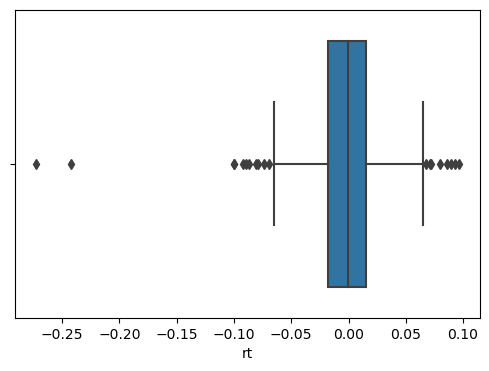

IQR value for column rt is: 0.0337399367700606
Shape of data after outlier removal is:  (478, 5)


In [11]:
removeOutliers(df, "rt","1")
df = filtered_data
print("Shape of data after outlier removal is: ", df.shape)

# Step 3: Draw the histogram of the daily returns {𝑟𝑡}.

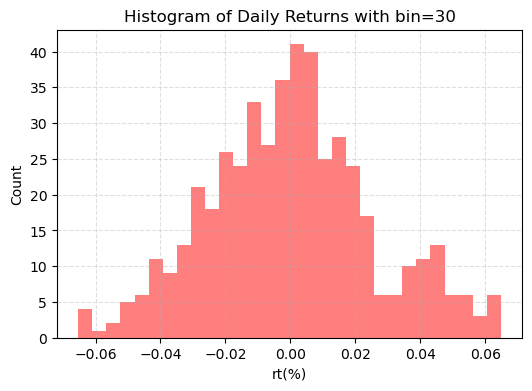

In [12]:
#parameter: bin=30<-498

plt.figure(figsize=(6, 4))
df["rt"].hist(color='r', alpha=0.5, bins=30)
plt.grid(ls='--',alpha=0.4)
plt.title('Histogram of Daily Returns with bin=30') #Figure1
plt.xlabel('rt(%)') 
plt.ylabel('Count') 
plt.savefig("/kaggle/working/Figure_1.png")
plt.show()

# Question 1: 
* What does this histogram look like? 
* Is it symmetrical around the mean? 
* Does it have heavier left tails or right tails?

1. **The histogram looks like normal distribution.**
1. **It is generally symmetrical around the mean.**
1. **I think there does't have a left tails but some outliers on the left hand side.**

# Question 2: 
Calculate the sample mean, sample variance, sample skewness and sample kurtosis.

Nan = 0
rt_mean is 0.00016479709163051546
rt_std is 0.025429492969941136
rt_var is 0.0006466591127082857
rt_skew is 0.17713344907215
rt_kurt is -0.09098613565014624
rt as KstestResult(statistic=0.47418760854118625, pvalue=3.2774304694411284e-99)
The data aren't normally distributed by Judging the p-value


It can be observed from qqplot that data is subject to normal distribution, which is caused by reasons such as kstest may not be applicable or data samples are not sufficient.


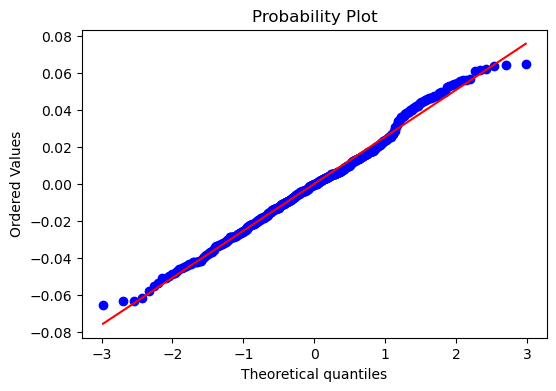

The distribution is symmetric by skew.


In [13]:
rt_s = Statistics_Normal_test(df["rt"], "rt", "2")

# Step 4: Use the normal distribution to fit the daily returns. Plot the histogram and the fitted normal curve in one figure.

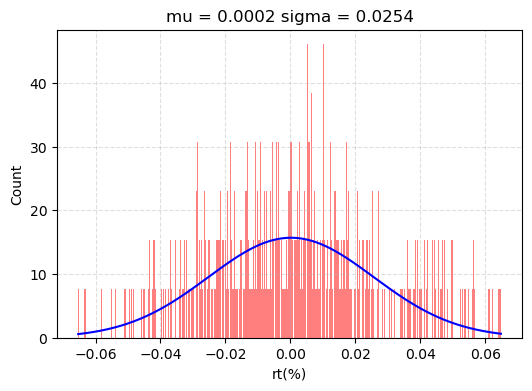

In [14]:
fit_rt = Fit_normal(df["rt"], "rt(%)", "2")

# Question 3: 
* What is the fitted expected return with normal distribution? 
* What is the fitted standard deviation?

In [15]:
fit_mean = np.mean(fit_rt)
fit_std = np.std(fit_rt, ddof=1)
print(fit_mean, fit_std)

7.591590114887446 5.244003293456913


# Question 4: 
Does the normal distribution fit the sample distribution well?

In [16]:
loss_1=Loss(df["rt"].values, fit_rt)

SSE= 40667.56465750687 
MSE= 85.07858714959596 
RMSE= 9.223805459223215 
MAE= 7.5914253177958155 
MAPE= 308035715474703.44 
R2= -131841.1828317757 
p-value= 3.2774304694411284e-99


# Step 5: Calculate the log returns.
log_rt = ln(St)-ln(S(t-1))

In [17]:
df["ln_st"] = np.log(df["st"])
df["ln_st_1"] = np.log(df["st_1"])
df["log_rt"] = df["ln_st"]-df["ln_st_1"]
df.head(5)

,date,close,st,st_1,rt,ln_st,ln_st_1,log_rt
2147,2021-02-02,109.01,109.01,106.92,0.019547,4.691440,4.672081,0.019359
2148,2021-02-03,108.82,108.82,109.01,-0.001743,4.689695,4.691440,-0.001744
2149,2021-02-04,110.74,110.74,108.82,0.017644,4.707185,4.689695,0.017490
2150,2021-02-05,114.62,114.62,110.74,0.035037,4.741622,4.707185,0.034437
2151,2021-02-08,112.20,112.20,114.62,-0.021113,4.720283,4.741622,-0.021339


# Step 6: Use normal distribution to fit the log returns. 
* That is, we try to use log-normal distributions to fit the series {𝑆𝑡/𝑆(𝑡−1)}.
* Plot the histogram of {𝑆𝑡/𝑆(𝑡−1)} and the fitted log-normal distribution curve in one figure.

Nan = 0
log_rt_mean is -0.0001570987117443163
log_rt_std is 0.025387869358943424
log_rt_var is 0.0006445439105867784
log_rt_skew is 0.10569995638762275
log_rt_kurt is -0.10075427699845152
log_rt as KstestResult(statistic=0.4749877772954487, pvalue=1.4497928562450066e-99)
The data aren't normally distributed by Judging the p-value


It can be observed from qqplot that data is subject to normal distribution, which is caused by reasons such as kstest may not be applicable or data samples are not sufficient.


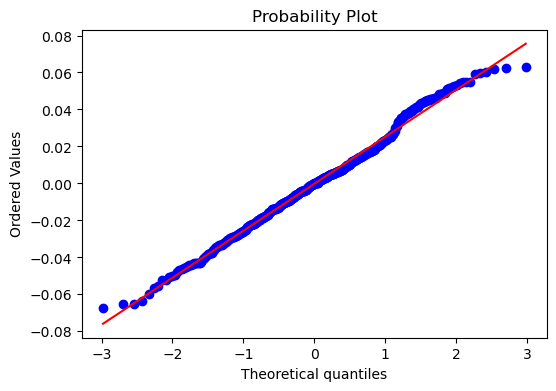

The distribution is symmetric by skew.


In [18]:
log_rt_s = Statistics_Normal_test(df["log_rt"], "log_rt", "3")

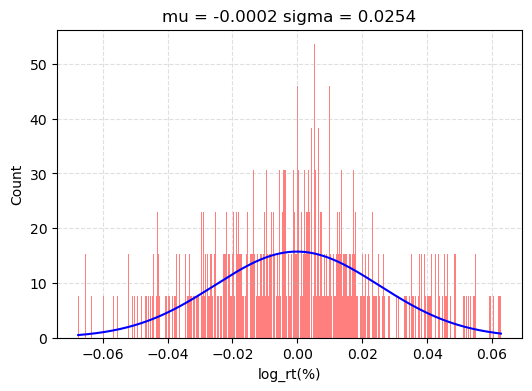

In [19]:
fit_log_rt = Fit_normal(df["log_rt"], "log_rt(%)", "3")

# Question 5:
* What is the fitted expected log return? 
* What is the fitted standard deviation?

In [20]:
fit_log_mean = np.mean(fit_log_rt)
fit_log_std = np.std(fit_log_rt, ddof=1) #sample standard deviation
print(fit_log_mean, fit_log_std)

7.578389677865422 5.262399501606586


# Question 6:
Of the normal distribution and the lognormal distribution, which one fits the data 
better? Why?

**Lognormal distribution is better.**

In [21]:
loss_2=Loss(df["log_rt"], fit_log_rt)

SSE= 40666.37746504367 
MSE= 85.07610348335496 
RMSE= 9.223670824750576 
MAE= 7.578546776577166 
MAPE= 306063108588974.25 
R2= -132269.98835953226 
p-value= 1.4497928562450066e-99


In [22]:
evaluate = { 'Evaluation Matrix':["SSE", "MSE", "RMSE", "MAE", "MAPE", "R2", "p-value"],
    'loss_rt': loss_1,
    'loss_log_rt': loss_2}
pd.DataFrame(evaluate)

,Evaluation Matrix,loss_rt,loss_log_rt
0,SSE,4.066756e+04,4.066638e+04
1,MSE,8.507859e+01,8.507610e+01
2,RMSE,9.223805e+00,9.223671e+00
3,MAE,7.591425e+00,7.578547e+00
4,MAPE,3.080357e+14,3.060631e+14
5,R2,-1.318412e+05,-1.322700e+05
6,p-value,3.277430e-99,1.449793e-99
